# Linear Regression in caffe2
- generate random data as input
- build network
- train model
- inspect the result and params variation

In [2]:
from caffe2.python import workspace,core,net_drawer,visualize
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Build initial network
init_net = core.Net('init')
# ground truth params
W_gt = init_net.GivenTensorFill([], 'W_gt', shape=[1, 2], values=[2.0, 1.5])
B_gt = init_net.GivenTensorFill([], 'B_gt', shape=[1,], values=[0.5])
ONE = init_net.ConstantFill([],'ONE', shape=[1,], value=1.0) # used in weighted sum when updating params
ITER = init_net.ConstantFill([],'ITER', shape=[1,], value=0, dtype=core.DataType.INT32) # number of iteration

# randomly initialize params
W = init_net.UniformFill([], 'W', shape=[1, 2], min=-1., max=1.)
B = init_net.ConstantFill([], 'B', shape=[1,], value=0.0)
print "Created init net."

# Build main training network
train_net = core.Net('train')
# Generate random samples
X = train_net.GaussianFill([], 'X', shape=[64, 2], mean=0.0, std=1.0, run_once=0)
Y_gt = X.FC([W_gt, B_gt], 'Y_gt')
# Add noise to ground truth
noise = train_net.GaussianFill([], 'noise', shape=[64, 1], mean=0.0, std=1.0, run_once=0)
Y_noise = Y_gt.Add(noise, 'Y_noise')
Y_noise = Y_noise.StopGradient([], 'Y_noise')

# Liner regression
Y_pred = X.FC([W, B], 'Y_pred')

# Add loss function and average on batch
dist = train_net.SquaredL2Distance([Y_noise, Y_pred], 'dist')
loss = dist.AveragedLoss([], ['loss'])

Created init net.


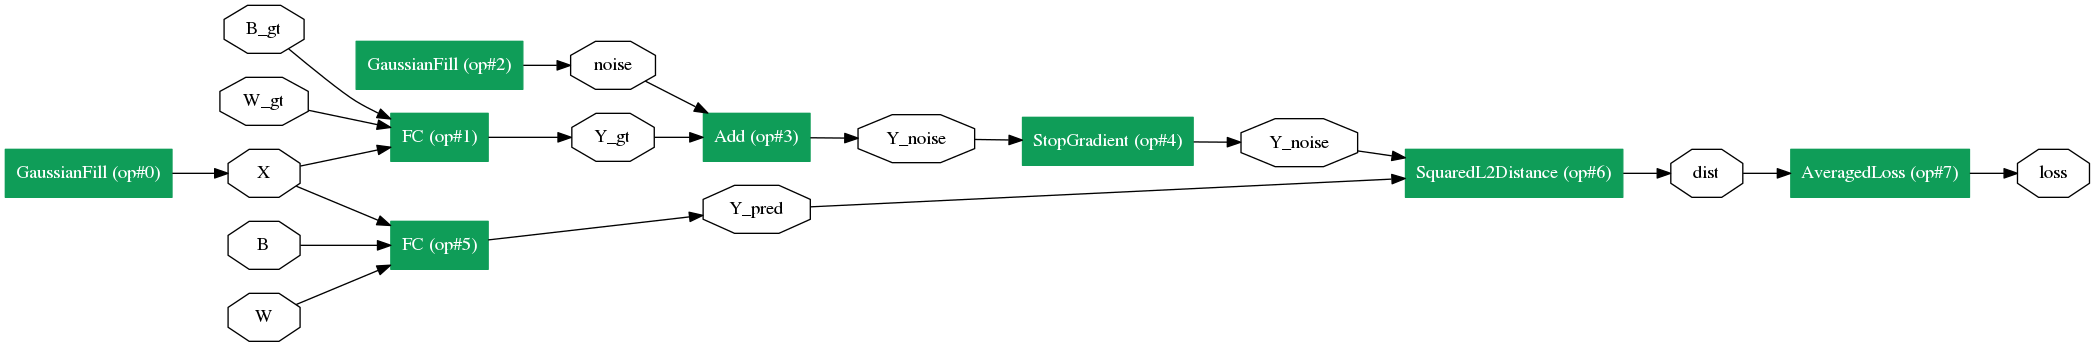

In [8]:
from IPython.core import display
graph = net_drawer.GetPydotGraph(train_net.Proto().op, 'train', rankdir='LR')
display.Image(graph.create_png(), width=800)

In [20]:
# Add gradient 
gradient_map = train_net.AddGradientOperators([loss])

In [21]:
# Use gradient to perform SGD
# ITER plus 1
train_net.Iter(ITER, ITER)
# Compute LR
LR = train_net.LearningRate(ITER, 'LR', base_lr=-0.1, policy='step', stepsize=20, gamma=0.9)
# Update W and B
train_net.WeightedSum([W, ONE, gradient_map[W], LR], W)
train_net.WeightedSum([B, ONE, gradient_map[B], LR], B)

BlobReference("B")

Before training, W is:[[-0.38516325  0.23120654]]
Before training, B is:[0.]
After training, W is:[[2.0478709 1.4877456]]
After training, B is:[0.4919796]


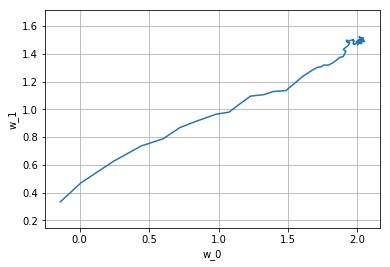

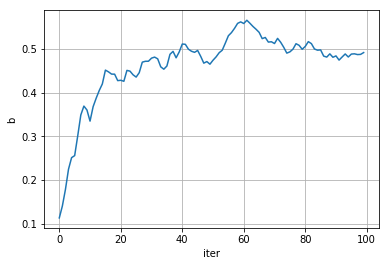

In [25]:
workspace.RunNetOnce(init_net)
workspace.CreateNet(train_net, overwrite=True)
print "Before training, W is:{}".format(workspace.FetchBlob('W'))
print "Before training, B is:{}".format(workspace.FetchBlob('B'))
w_history = []
b_history = []
for i in range(100):
    workspace.RunNet(train_net.Proto().name)
    w_history.append(workspace.FetchBlob('W'))
    b_history.append(workspace.FetchBlob('B'))
w_history = np.vstack(w_history)
print "After training, W is:{}".format(workspace.FetchBlob('W'))
print "After training, B is:{}".format(workspace.FetchBlob('B'))   
plt.plot(w_history[:,0], w_history[:,1])
plt.axis('equal')
plt.xlabel('w_0')
plt.ylabel('w_1')
plt.grid(True)
plt.figure()
plt.plot(b_history)
plt.xlabel('iter')
plt.ylabel('b')
plt.grid(True)
plt.show()